In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
from load_5hot import load
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, Add, Reshape
from keras.layers import AveragePooling2D, UpSampling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
from keras.activations import softmax

K.set_image_data_format('channels_last')
print('Done')

Done


In [2]:
[X_train,Y_train,X_test,Y_test] = load("blast_tab_1hit.out")

Loading data...
58863 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done


In [7]:
m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

There are 55996 training examples
There are 2867 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(55996, 5, 308, 1)


In [8]:
print('Permuting...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

Permuting...
finished X
finished Y


In [9]:
# Visualize data sets to ensure they appear as anticipated
sample = 300
print(X_train[sample,:,10:30,0])
print(Y_train[sample,:,10:30,0])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [55]:
ngf = 16
input_nc = 1
output_nc = 1
n_blocks_gen = 9

def softMaxAxis1(x):
    return softmax(x,axis=1)

# started from: https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5
def Model_1(input_shape):
    """Build generator architecture."""
    # Current version : ResNet block
    X_input = Input(input_shape)
    
    # X = ZeroPadding2D((0, 3))(X_input) # allows 'valid' in conv0 to keep length and collapse one-hot

    X = Conv2D(128, (4, 7), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
#     X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv1')(X)
#     X = BatchNormalization(axis = 3, name = 'bn1')(X)
#     X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3, name = 'dropout')(X)
   
    X = Conv2D(32, (1, 7), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Dense(1, activation = softMaxAxis1)(X)
    
    model = Model(inputs=X_input, outputs=X, name='Model_2')
    return model

In [56]:
myModel = Model_1((5,max_length,1))
print(myModel.summary())
print('Done!')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_33 (Activation)   (None, 5, 308, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_34 (Activation)   (None, 5, 308, 64)        0         
__________

In [57]:
myModel.compile(optimizer="Adam", loss="mean_squared_error", metrics = ["accuracy"])
print('Done!')

Done!


In [47]:
# Understand baseline accuracy of if model output its own input
diffs = np.absolute(X_test-Y_test);
err = np.sum(diffs)/np.ma.size(X_test);
print("Baseline accuracy if predicting output = input is " + str(1-err))

Baseline accuracy if predicting output = input is 0.9923885322908692


In [ ]:
history = myModel.fit(x = X_train, y = Y_train, epochs = 3, validation_split = 0.01, batch_size = 30, verbose = 1)

loss_and_acc = myModel.evaluate(X_test, Y_test)
print(loss_and_acc)

currtime = datetime.datetime.now()
fname = "./convWeights/" + currtime.strftime("%m%d-%H%M") + "_5hot.hdf5"
print(fname)
myModel.save_weights(fname)

Train on 55436 samples, validate on 560 samples
Epoch 1/3
 1050/55436 [..............................] - ETA: 33:29 - loss: 0.0228 - acc: 0.9837

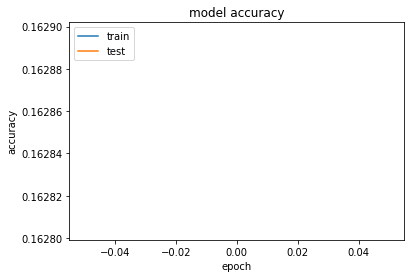

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
preds = myModel.predict(x = X_test)

In [63]:
# Change n to view the predictions, true sequence, and input sequence for a given sample
n = 4
print(preds.shape)
print("Sample number " + str(n+1))
samp_n_pred = preds[n,0:5,:,0]
samp_n_in = X_test[n,0:5,:,0]
samp_n_true = Y_test[n,0:5,:,0]

np.set_printoptions(precision=3, suppress=True)
noise = np.argmax(np.sum(np.square(samp_n_in - samp_n_true),axis=0))
print("The noise was at nucleotide number " + str(noise))
print("The predictions from " + str(noise-2) + " to " + str(noise+2) + " are: ")
print(preds[n,0:5,noise-2:noise+3,0])
print("The true denoised nucleotides from " + str(noise-2) + " to " + str(noise+2) + " are: ")
print(Y_test[n,0:5,noise-2:noise+3,0])
print("The input nucleotides from " + str(noise-2) + " to " + str(noise+2) + " were: ")
print(X_test[n,0:5,noise-2:noise+3,0])

(2867, 5, 308, 1)
Sample number 5
The noise was at nucleotide number 40
The predictions from 38 to 42 are: 
[[0.206 0.202 0.208 0.196 0.2  ]
 [0.199 0.197 0.199 0.194 0.204]
 [0.197 0.207 0.196 0.202 0.202]
 [0.195 0.194 0.197 0.207 0.194]
 [0.202 0.2   0.199 0.201 0.2  ]]
The true denoised nucleotides from 38 to 42 are: 
[[1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
The input nucleotides from 38 to 42 were: 
[[1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [11]:
myModel.load_weights("./convWeights/0520-1212.hdf5")